In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
import sys
sys.path.append("../")

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import least_squares

from stereoVO.structures import StateBolts, VO_StateMachine
from stereoVO.datasets import KittiDataset
from stereoVO.configs import yaml_parser
from stereoVO.utils import rmse_error
from stereoVO.optimization import get_minimization
from stereoVO.geometry import (DetectionEngine,
                               TrackingEngine,
                               filter_matching_inliers, 
                               triangulate_points, 
                               filter_triangulated_points,
                               project_points)

In [ ]:
PATH = '../../KITTI/KITTI_gray/dataset/sequences/00/'
CONFIG_PATH =  '../configs/params.yaml'

**Initialise the dataset**

In [ ]:
dataset = KittiDataset(PATH)

**Load the Configs**

In [ ]:
params = yaml_parser(CONFIG_PATH)

**Initialise the State**

In [ ]:
state_num = 0

left_frame, right_frame, ground_truth = dataset[state_num]

#initialise the state
prevState = VO_StateMachine(state_num)

#set frame state
prevState.frames = left_frame, right_frame

**Detction Engine, Matching and Triangulation for first frame**

In [ ]:
detection_engine = DetectionEngine(prevState.frames.left, prevState.frames.right, params)

prevState.matchedPoints, prevState.keypoints, prevState.descriptors = detection_engine.get_matching_keypoints()

prevState.inliers, mask_epipolar = filter_matching_inliers(prevState.matchedPoints.left,
                                            prevState.matchedPoints.right,
                                            dataset.intrinsic,
                                            params)

prevState.pts3D, reproj_error = triangulate_points(prevState.inliers.left,
                                    prevState.inliers.right,
                                    dataset.PL,
                                    dataset.PR)

args_triangulation = params.geometry.triangulation
prevState.pts3D_Filter, maskTriangulationFilter, ratioFilter = filter_triangulated_points(prevState.pts3D, reproj_error, **args_triangulation)

prevState.InliersFilter = prevState.inliers.left[maskTriangulationFilter], prevState.inliers.right[maskTriangulationFilter]
prevState.ratioTriangulationFilter = ratioFilter

**Initialize the pose of the camera**

In [ ]:
prevState.location = np.array(params.initial.location)
prevState.orientation = np.array(params.initial.orientation)

In [ ]:
ground_truth_location = dataset.ground_truth[0][:,-1]
ground_truth_orientation = dataset.ground_truth[0][:,:-1]

In [ ]:
rmse_error(prevState.location, ground_truth_location)

3.220922637035219e-16

**Initialise the Second State and set it as currState**

In [ ]:
state_num = 1

left_frame, right_frame, ground_truth = dataset[state_num]

#initialise the state
currState = VO_StateMachine(state_num)

#set frame state
currState.frames = left_frame, right_frame

In [ ]:
detection_engine = DetectionEngine(currState.frames.left, currState.frames.right, params)

currState.matchedPoints, currState.keypoints, currState.descriptors = detection_engine.get_matching_keypoints()

currState.inliers, mask_epipolar = filter_matching_inliers(currState.matchedPoints.left,
                                            currState.matchedPoints.right,
                                            dataset.intrinsic,
                                            params)

currState.pts3D, reproj_error = triangulate_points(currState.inliers.left,
                                    currState.inliers.right,
                                    dataset.PL,
                                    dataset.PR)

args_triangulation = params.geometry.triangulation
currState.pts3D_Filter, maskTriangulationFilter, ratioFilter = filter_triangulated_points(currState.pts3D, reproj_error, **args_triangulation)

currState.InliersFilter = currState.inliers.left[maskTriangulationFilter], currState.inliers.right[maskTriangulationFilter]
currState.ratioTriangulationFilter = ratioFilter

In [ ]:
prevFrames = prevState.frames
currFrames = currState.frames
prevInliers = prevState.InliersFilter

**Feature Tracking from prev state to current state**

In [ ]:
tracker = TrackingEngine(prevFrames, currFrames, prevInliers, dataset.intrinsic, params)

In [ ]:
tracker.process_tracked_features()

In [ ]:
prevState.inliersTracking, currState.pointsTracked, prevState.pts3D_Tracking = tracker.filter_inliers(prevState.pts3D_Filter)                      

**P3P Solver**

In [ ]:
args_pnpSolver = params.geometry.pnpSolver


for i in range(args_pnpSolver.numTrials):
    
    retval, r_vec, t_vec, idxPose = cv2.solvePnPRansac(prevState.pts3D_Tracking,
                                                       currState.pointsTracked.left,
                                                       dataset.intrinsic,
                                                       None,
                                                       iterationsCount=args_pnpSolver.numTrials,
                                                       reprojectionError=args_pnpSolver.reprojectionError,
                                                       confidence=args_pnpSolver.confidence,
                                                       flags=cv2.SOLVEPNP_P3P)
    
    
    r_mat, _ = cv2.Rodrigues(r_vec)
    
    # r_vec and t_vec obtained are in camera coordinate frames
    # we need to convert these matrix in world coordinates system
    # or we need to transforms the matrix from currState to prevState
    t_vec = -r_mat.T @ t_vec
    r_mat = r_mat.T
    
    idxPose = idxPose.flatten()
    
    ratio = len(idxPose)/len(prevState.pts3D_Tracking)
    scale = np.linalg.norm(t_vec)
    
    if scale<args_pnpSolver.deltaT and ratio>args_pnpSolver.minRatio:
        print("Scale of translation of camera     : {}".format(scale))
        print("Solution obtained in P3P Iteration : {}".format(i+1))
        print("Ratio of Inliers                   : {}".format(ratio))
        break
    else:
        print("Warning : Max Iter : {} reached, still large position delta produced".format(i))

Scale of translation of camera     : 0.6764176064655109
Solution obtained in P3P Iteration : 1
Ratio of Inliers                   : 0.8963068181818182


**Non-linear Least Square Optimization of Pose**

In [ ]:
optimisation=True

if optimisation:
    
    # Convert the matrix from world coordinates(prevState) to camera coordinates (currState)
    t_vec = -r_mat.T @ t_vec
    r_mat = r_mat.T
    r_vec, _ = cv2.Rodrigues(r_mat)
    
    # Prepare an initial set of parameters to the optimizer
    doF = np.concatenate((r_vec, t_vec)).flatten()
 
    # Prepare the solver for minimization
    optRes = least_squares(get_minimization, doF, method='lm', max_nfev=2000,
                            args=(prevState.pts3D_Tracking, 
                                  currState.pointsTracked.left, 
                                  currState.pointsTracked.right, 
                                  dataset.PL,dataset.PR))
    
    # r_vec and t_vec obtained are in camera coordinate frames (currState)
    # we need to convert these matrix to world coordinates system (prevState)
    opt_rvec_cam = (optRes.x[:3]).reshape(-1,1)
    opt_tvec_cam = (optRes.x[3:]).reshape(-1,1)
    opt_rmat_cam,_ = cv2.Rodrigues(opt_rvec_cam)
    
    # Obtain the pose of the camera (wrt state of the previous camera)
    r_mat = opt_rmat_cam.T
    t_vec = -opt_rmat_cam.T @ opt_tvec_cam

In [ ]:
currState.pointsTracked = (currState.pointsTracked.left[idxPose], currState.pointsTracked.right[idxPose])
prevState.P3P_pts3D = prevState.pts3D_Tracking[idxPose]

In [ ]:
# Upating the pose of the camera of currState 
# According to the Vo tutorial by Dacvid Scaramuzza 
# C_n = C_n-1 * dTn-1
# where the dTn-1 is in the coordinate frame of the second camera
# Link : http://rpg.ifi.uzh.ch/docs/VO_Part_I_Scaramuzza.pdf

**Pose Updation**

In [ ]:
currState.orientation = prevState.orientation @ r_mat
currState.location = prevState.orientation @ t_vec + prevState.location.reshape(-1,1)
currState.location = currState.location.flatten()

In [ ]:
ground_truth_location = dataset.ground_truth[state_num][:,-1]
ground_truth_orientation = dataset.ground_truth[state_num][:,:-1]

In [ ]:
currState.location

array([ 0.03857642, -0.00166897,  0.66551932])

In [ ]:
ground_truth_location

array([-0.04690294, -0.02839928,  0.8586941 ], dtype=float32)

In [ ]:
rmseError = rmse_error(ground_truth_location, currState.location)

**Record landmark information**

In [ ]:
currState.landmark = prevState.P3P_pts3D
currState.keypoints = currState.pointsTracked

**Plot Camera**

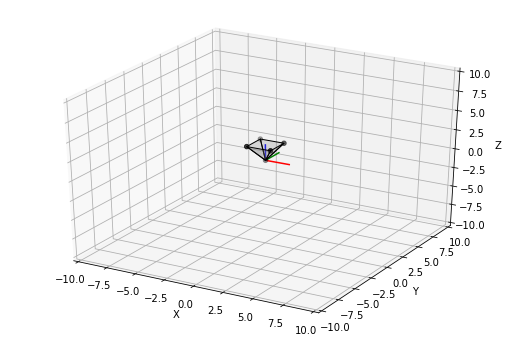

In [ ]:
import matplotlib.pyplot as plt 
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

fig = plt.figure(figsize=(9,6))
ax = fig.add_subplot(111, projection='3d')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

ax.set_xlim3d(-10, 10)
ax.set_ylim3d(-10, 10)
ax.set_zlim3d(-10, 10)

ax.view_init()

axes = np.zeros((3,6))
axes[0,1], axes[1,3],axes[2,5] = 2,2,2
axes= r_mat @ (axes) + np.tile(t_vec,(1,6))

ax.plot3D(xs=axes[0,:2],ys=axes[1,:2],zs=axes[2,:2],c='r')
ax.plot3D(xs=axes[0,2:4],ys=axes[1,2:4],zs=axes[2,2:4],c='g')
ax.plot3D(xs=axes[0,4:],ys=axes[1,4:],zs=axes[2,4:],c='b')

scale=1
depth=2

#generating 5 corners of camera polygon 
pt1 = np.array([[0,0,0]]).T #camera centre
pt2 = np.array([[scale,-scale,depth]]).T #upper right 
pt3 = np.array([[scale,scale,depth]]).T #lower right 
pt4 = np.array([[-scale,-scale,depth]]).T #upper left
pt5 = np.array([[-scale,scale,depth]]).T #lower left
pts = np.concatenate((pt1,pt2,pt3,pt4,pt5),axis=-1) 

#Transforming to world-coordinate system
pts = r_mat @ (pts) + np.tile(t_vec,(1,5))
ax.scatter3D(xs=pts[0,:],ys=pts[1,:],zs=pts[2,:],c='k')

#Generating a list of vertices to be connected in polygon
verts = [[pts[:,0],pts[:,1],pts[:,2]], [pts[:,0],pts[:,2],pts[:,-1]],
        [pts[:,0],pts[:,-1],pts[:,-2]],[pts[:,0],pts[:,-2],pts[:,1]]]

#Generating a polygon now..
ax.add_collection3d(Poly3DCollection(verts, facecolors='grey',
                                     linewidths=1, edgecolors='k', alpha=.25))
plt.show()

In [ ]:
r_mat.shape

(3, 3)

In [ ]:
t_vec.shape

(3, 1)

In [ ]:
def draw_trajectory_3D(r_mat, t_vec, figSize=(9,6)):

    fig = plt.figure(figsize=figSize)
    ax = fig.add_subplot(111, projection='3d')

    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')

    ax.set_xlim3d(-300, 300)
    ax.set_ylim3d(-300, 300)
    ax.set_zlim3d(-500, 500)

    ax.view_init()

    axes = np.zeros((3,6))
    axes[0,1], axes[1,3],axes[2,5] = 2,2,2
    t_vec = t_vec.reshape(-1,1)
    axes= r_mat @ (axes) + np.tile(t_vec,(1,6))

    ax.plot3D(xs=axes[0,:2],ys=axes[1,:2],zs=axes[2,:2],c='r')
    ax.plot3D(xs=axes[0,2:4],ys=axes[1,2:4],zs=axes[2,2:4],c='g')
    ax.plot3D(xs=axes[0,4:],ys=axes[1,4:],zs=axes[2,4:],c='b')

    scale=50
    depth=100

    #generating 5 corners of camera polygon 
    pt1 = np.array([[0,0,0]]).T #camera centre
    pt2 = np.array([[scale,-scale,depth]]).T #upper right 
    pt3 = np.array([[scale,scale,depth]]).T #lower right 
    pt4 = np.array([[-scale,-scale,depth]]).T #upper left
    pt5 = np.array([[-scale,scale,depth]]).T #lower left
    pts = np.concatenate((pt1,pt2,pt3,pt4,pt5),axis=-1) 

    #Transforming to world-coordinate system
    pts = r_mat @ (pts) + np.tile(t_vec,(1,5))
    ax.scatter3D(xs=pts[0,:],ys=pts[1,:],zs=pts[2,:],c='k')

    #Generating a list of vertices to be connected in polygon
    verts = [[pts[:,0],pts[:,1],pts[:,2]], [pts[:,0],pts[:,2],pts[:,-1]],
            [pts[:,0],pts[:,-1],pts[:,-2]],[pts[:,0],pts[:,-2],pts[:,1]]]
    
    #Generating a polygon now..
    ax.add_collection3d(Poly3DCollection(verts, facecolors='grey',
                                        linewidths=1, edgecolors='k', alpha=.25))

    plt.show()

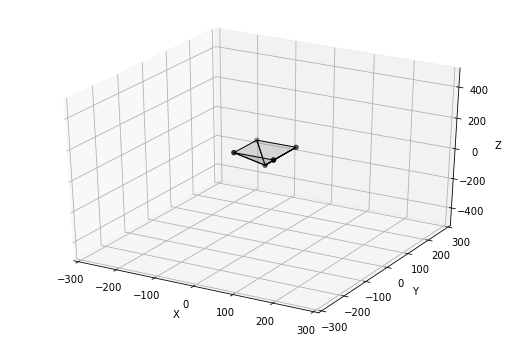

In [ ]:
draw_trajectory_3D(prevState.orientation, prevState.location)